In [ ]:
# ML_in_Finance_IRL_FCW
# Version: 1.0 (28.4.2020)
# License: MIT
# Email: paul@thalesians.co.uk and matthew.dixon@iit.edu
# Notes: tested on Mac OS X running Python 3.6.9 with the following packages:
# numpy=1.18.1, matplotlib=3.1.3, tensorflow=2.0.0, pytorch=1.5.0
# Citation: Please cite the following reference if this notebook is used for research purposes:
# Dixon M.F., Halperin I. and P. Bilokon, Machine Learning in Finance: From Theory to Practice, Springer Graduate Textbook Series, 2020.

## Inverse Reinforcement Learning for Financial Cliff Walking

This notebook contains implementations of three IRL algorithms for the Financial Cliff Walking (FCW) problem:

1. Max Causal Entropy IRL

2. IRL from Failure (IRLF) 

3. T-REX

The notebook is self-contained, training data and ground truth are generated within the notebook.

In [1]:
import matplotlib.pyplot as plt 
%matplotlib inline

import numpy as np
import time

# To ignore warnings that are annoying.
import warnings
warnings.filterwarnings('ignore')

## Setup

In [2]:
# Global variables
# N - World height
# T - World width
WORLD_HEIGHT = 4
WORLD_WIDTH = 12

# Probability for exploration - epsilon
EPSILON = 0.1
# Step size
ALPHA = 0.001
# Gamma - discount factor - for Q-Learning, Sarsa and Expected Sarsa
GAMMA = 0.9

# Actions - ACTION_UP is a+ (adding a deposit), ACTION_DOWN is a-(redeeming a deposit) and 
# ACTION_ZERO is a0 (leaving the account as it is).
ACTION_UP = 0
ACTION_DOWN = 1
ACTION_ZERO = 2
ACTIONS = [ACTION_UP, ACTION_DOWN, ACTION_ZERO]

# Initial and Goal states
START = [1,0]
GOAL = [0, WORLD_WIDTH-1]

## Functions determining the step

In [3]:
# Step function that describes how the next state is obtained from the current state and the action 
# taken. The function returns the next state and the reward obtained.
def step(state, action):
    i, j = state

    if state[0] == 0 and (state[1] > 0): #  and state[1] < WORLD_WIDTH - 2):
        # remain in the bankruptcy state
        next_state =  [0, min(j + 1, WORLD_WIDTH - 1)]
        reward = 0 
        return next_state, reward
    
    # if at the final time, next state is the same, and reward is zero
    if state[1] == WORLD_WIDTH - 1:
        next_state = [i,state[1]]
        reward = 0
        return next_state, reward
    
    if action == ACTION_UP:
        next_state = [min(i + 1, WORLD_HEIGHT-1), min(j + 1, WORLD_WIDTH - 1)]
    elif action == ACTION_DOWN:
        next_state = [max(i - 1, 0), min(j + 1, WORLD_WIDTH - 1)]
    elif action == ACTION_ZERO:
        next_state = [i, min(j + 1, WORLD_WIDTH - 1)]
    else:
        assert False
    
    # The reward is -1 for actions ACTION_UP and ACTION_DOWN. This is done to keep transactions to a minimum.
    reward = -1
    
    # ACTION_ZERO gets a zero reward since we want to minimize the number of transactions
    if action == ACTION_ZERO:
        reward = 0
    
    # Exceptions are 
    # i) If bankruptcy happens before WORLD_WIDTH time steps
    # ii) No deposit at initial state
    # iii) Redemption at initial state!
    # iv) Any action carried out from a bankrupt state
    if ((action == ACTION_DOWN and i == 1 and 1 <= j < 10) or (
        action == ACTION_ZERO and state == START) or (
        action == ACTION_DOWN and state == START )) or (
        i == 0 and 1 <= j <= 10):    
            reward = -100
        
    # Next exception is when we get to the final time step.
    if state[0] != 0 and (next_state[1] == WORLD_WIDTH - 1): 
        # override a random action by a deterministic action=ACTION_DOWN
        if (next_state[0] == 0): # Action resulted in ending with zero balance in final time step
            reward = 10
        else:
            reward = -10   
        
    return next_state, reward

# Choose an action based on epsilon greedy algorithm
def choose_action(state, q_value, eps=EPSILON):
    if np.random.binomial(1, eps) == 1:
        action = np.random.choice(ACTIONS)
    else:
        values_ = q_value[state[0], state[1], :]
        action = np.random.choice([action_ for action_, value_ in enumerate(values_) 
                                 if value_ == np.max(values_)])
    # From bankrupt state there is no meaningful action, so we will assign 'Z' by convention.
    if state[0] == 0 and state[1] > 0:
        action = ACTION_ZERO
    return action
    

## Functions for MaxEnt IRL

In [4]:
def pos2idx(pos):
    """
    input:
      column-major 2d position
    returns:
      1d index
    """
    return np.ravel_multi_index((pos[0], pos[1]), (WORLD_HEIGHT, WORLD_WIDTH))

def idx2pos(idx):
        
    """
    input:
      1d idx
    returns:
      2d column-major position
    """
    
    pos = [np.unravel_index(idx, (WORLD_HEIGHT, WORLD_WIDTH))[0],
           np.unravel_index(idx, (WORLD_HEIGHT, WORLD_WIDTH))[1]]
    return pos 

'''
Functions get_transition_mat, value_iteration, compute_state_visition_freq
defined below are adapted from this reference:

https://github.com/yrlu/irl-imitation

Implementation of maximum entropy inverse reinforcement learning in
  Ziebart et al. 2008 paper: Maximum Entropy Inverse Reinforcement Learning
  https://www.aaai.org/Papers/AAAI/2008/AAAI08-227.pdf

By Yiren Lu (luyirenmax@gmail.com), May 2017
'''

def get_transition_mat():
    
    """
    get transition dynamics of the gridworld

    return:
      P_a         NxNxN_ACTIONS transition probabilities matrix - 
                    P_a[s0, s1, a] is the transition prob of 
                    landing at state s1 when taking action 
                    a at state s0
                    
    Probabilities are ones for transitions to states produced by function step(state,action)
    """
    n_states = WORLD_HEIGHT * WORLD_WIDTH
    n_actions = len(ACTIONS)
    
    P_a = np.zeros((n_states, n_states, n_actions))
    
    for si in range(1, n_states): 
        for a in ACTIONS:            
            next_state, reward = step(idx2pos(si),a)
            sj = pos2idx(next_state)                         
            P_a[int(si), int(sj), int(a)] = 1

    return P_a

def get_true_rewards():
    """
    get the reward matrix of shape n_states x n_actions
    """
    n_states = WORLD_HEIGHT * WORLD_WIDTH
    n_actions = len(ACTIONS)
    
    gt_rewards = np.zeros((n_states, n_actions))
    for si in range(n_states):
        for a in ACTIONS:            
            next_state, reward = step(idx2pos(si),a)                        
            gt_rewards[int(si), int(a)] = reward
    
    return gt_rewards
    
def get_rewards_on_rectangle(rewards, action): # matrix of size n_state x n_action
                            
    # convert rewards into rectangular form WORLD_HEIGHT x WORLD_WIDTH
    rewards_rectangle = np.zeros((WORLD_HEIGHT, WORLD_WIDTH))
    n_states = rewards.shape[0]
    
    for idx in range(n_states):
        height, width = idx2pos(idx)
        rewards_rectangle[height,width] = rewards[idx,action]
    
    return rewards_rectangle

def get_values_on_rectangle(values): # here values are given by the vector of size n_states
    
    values_rectangle = np.zeros((WORLD_HEIGHT, WORLD_WIDTH))
    n_states = len(values)
    
    for idx in range(n_states):
        height, width = idx2pos(idx)
        values_rectangle[height,width] = values[idx]
    
    return values_rectangle
    
def value_iteration(P_a, rewards, gamma, error=0.01, deterministic=False):
    
    
    """
    static value iteration function
  
    inputs:
    P_a         N x N x N_ACTIONS transition probabilities matrix - 
                              P_a[s0, s1, a] is the transition prob of 
                              landing at state s1 when taking action 
                              a at state s0
    rewards     N x N_ACTIONS matrix - rewards for all the state-action combinations
    gamma       float - RL discount
    error       float - threshold for a stop
    deterministic   bool - to return deterministic policy or stochastic policy
  
    returns:
    values    Nx1 matrix - estimated values
    policy    Nx1 (NxN_ACTIONS if non-det) matrix - policy
    """
    n_states, _, n_actions = np.shape(P_a)

    values = np.zeros([n_states])

    # estimate values
    while True:
        values_tmp = values.copy()

        for s in range(n_states):
            v_s = []
            values[s] = max([sum([P_a[s, s1, a]*(rewards[s,a] + gamma*values_tmp[s1]) for s1 in range(n_states)]) 
                             for a in ACTIONS])    
        
        if max([abs(values[s] - values_tmp[s]) for s in range(n_states)]) < error:
            break


    if deterministic:
        # generate deterministic policy
        policy = np.zeros([n_states])
        for s in range(n_states):
            policy[s] = np.argmax([sum([P_a[s, s1, a]*(rewards[s,a]+gamma*values[s1]) 
                                  for s1 in range(n_states)]) 
                                  for a in ACTIONS])

        return values, policy
    else:
        # generate stochastic policy
        policy = np.zeros([n_states, n_actions])
        for s in range(n_states):
            v_s = np.array([sum([P_a[s, s1, a]*(rewards[s,a] + gamma*values[s1]) for s1 in range(n_states)]) 
                            for a in ACTIONS])
            policy[s,:] = np.transpose(v_s/np.sum(v_s))
        return values, policy
    
    
def soft_Q_iteration(rewards, gamma, beta, learn_rate_Q, n_states, n_actions, 
                     trajs, error=0.01, max_iter = 500):
    """
    Performs soft Q-iteration based on observed samples 
    Returns: the soft-Q function, soft-V function, and soft-Q policy
    
    """

    T = trajs.shape[1] 
    n_traj = trajs.shape[0]
    
    discounts = np.ones(T)
    for t in range(1,T):
        discounts[t] *= gamma
        
    # initialize
    soft_Q_vals =  np.zeros((n_states, n_actions))
    soft_Q_policy = np.zeros((n_states, n_actions))
    
    iter_idx = 0
    
    # soft-Q iteration
    while True:
        soft_Q_vals_tmp = soft_Q_vals.copy()
        
        for episode in range(n_traj):
            for t in range(T):
                state = trajs[episode,t,0]
                action = trajs[episode,t,1]
                next_state = trajs[episode,t,2]
                reward = rewards[state, action]
                
                soft_V_vals_next = (1.0/beta) * np.log(np.sum(np.exp(beta*soft_Q_vals[next_state,:])))
                soft_Q_vals[state, action] += learn_rate_Q*(reward + gamma * soft_V_vals_next 
                                                            - soft_Q_vals[state, action])
        
        iter_idx += 1
        if np.max(soft_Q_vals - soft_Q_vals_tmp) < error or iter_idx >= max_iter:
            break

    # soft V-function        
    soft_V_vals = (1.0/beta) * np.log(np.sum(np.exp(beta*soft_Q_vals),axis=1))
    
    # stochastic policy
    policy = np.exp(beta*(soft_Q_vals - np.tile(soft_V_vals[:, np.newaxis],(1,n_actions) )))
            
    return soft_Q_vals, soft_V_vals, policy


def soft_Q_iteration_mb(P_a, rewards, gamma, beta, n_states, n_actions, error=0.01):
    """
    Soft Q-iteration based on a transition model (model-based soft Q-iteration)
    """
    
    Q_values = np.zeros((n_states, n_actions))

    # estimate Q-values
    while True:
        Q_values_tmp = Q_values.copy()

        for s in range(n_states):
            for a in range(n_actions):   
                Q_values[s,a] = np.sum(P_a[s,:,a]*(rewards[s,a]
                                        + (gamma/beta)*np.log(np.sum(np.exp(beta*Q_values_tmp[:,:]),axis=1))))
        if np.max(np.abs(Q_values - Q_values_tmp)) < error:
            break

    # soft V-function        
    soft_V_vals = (1.0/beta) * np.log(np.sum(np.exp(beta*Q_values),axis=1))
    
    # stochastic policy
    policy = np.exp(beta*(Q_values - np.tile(soft_V_vals[:, np.newaxis],(1,n_actions) )))
            
    return Q_values, soft_V_vals, policy            
        
def compute_state_visition_freq(P_a, gamma, T, policy, deterministic=False):
    
    """compute the expected states visition frequency p(s| theta, T) 
    using dynamic programming

    inputs:
    P_a     N x N x N_ACTIONS matrix - transition dynamics
    gamma   float - discount factor
    trajs   list of list of Steps - collected from expert
    policy  N x 1 vector (or NxN_ACTIONS if deterministic=False) - policy
    T       number of time steps
  
    returns:
    svf       N x 1 vector - state visitation frequencies
    savf      N x N_ACTION - state-action visitation frequencies
    """
    n_states, _, n_actions = np.shape(P_a)
    
    # mu[s, t] is the prob of visiting state s at time t
    mu = np.zeros([n_states, T]) 
    
    # as all trajectories in our case start at [0,0], initialize the time-dependent state density at t = 0
    mu[pos2idx(START),0] = 1

    # compute mu[s,t] for other times 
    for s in range(n_states):
        for t in range(T-1):
            if deterministic:
                mu[s, t+1] = sum([mu[pre_s, t]*P_a[pre_s, s, int(policy[pre_s])] 
                                  for pre_s in range(n_states)])
            else:
                mu[s, t+1] = sum([sum([mu[pre_s, t]*P_a[pre_s, s, a1]*policy[pre_s, a1] 
                                       for a1 in ACTIONS]) for pre_s in range(n_states)])

    
    # array of discount factors
    discounts = np.ones(T)
    for i in range(1,T):
        discounts[i] = gamma * discounts[i-1]
    
    # state visitation frequencies
    svf = np.sum(mu * discounts, 1)
        
    # state-action visitation frequencies
    savf = np.tile(svf[:,np.newaxis],(1,n_actions)) * policy
    
    return svf, savf


def maxent_irl(feat_map, P_a, gamma, beta, lr, lr_Q, trajs, n_iters):
    
    """
    Maximum Entropy Inverse Reinforcement Learning (Maxent IRL)

    inputs:
        feat_map    NxD matrix - the features for each state
        P_a         NxNxN_ACTIONS matrix - P_a[s0, s1, a] is the transition prob of 
                                           landing at state s1 when taking action 
                                           a at state s0
        gamma       float - RL discount factor
        beta        regularization parameter for soft Q-learning
        lr          learning rate
        lr_Q        learning rate for soft Q-learning
        trajs       a list of demonstrations
        
        n_iters     int - number of optimization steps

    returns
        rewards     Nx1 vector - recoverred state rewards
    """
    n_states, _, n_actions = np.shape(P_a)

    # init parameters
    
    # theta is a matrix of parameters of shape n_states x n_actions, for actions = 0,1,2
    theta = np.random.uniform(low=-0.1,high=0.1, size=(feature_matrix.shape[1],n_actions))    

    # calc feature expectations
    feat_exp = np.zeros((feat_map.shape[1],n_actions))
    
    T = trajs.shape[1]
    n_traj = trajs.shape[0]
    
    discounts = np.ones(T)
    for t in range(1,T):
        discounts[t] *= gamma
    
    for episode in range(n_traj):
        for t in range(T):
            for a in ACTIONS:
                state = trajs[episode,t,0]
                action = trajs[episode,t,1]
                feat_exp[state, action] += discounts[t]
    
    feat_exp = feat_exp/n_traj 
    
    # training
    for iteration in range(n_iters):
  
        if iteration % (n_iters/20) == 0:
            print('iteration: {}/{}'.format(iteration, n_iters))
    
        # compute reward function as a matrix of shape n_states x n_actions, for actions = 0,1,2
        rewards = np.dot(feat_map, theta)
        
        # try computing policy using model-based soft Q-iteration
        _, _, policy = soft_Q_iteration_mb(P_a, rewards, gamma, beta, 
                                           n_states, n_actions, error=0.01)
    
        # compute state-action visition frequences
        _, savf = compute_state_visition_freq(P_a, gamma, T, policy, deterministic=False)
            
        # compute gradients
        grad = feat_exp - feat_map.T.dot(savf) # now gradient has shape n_states x n_actions

        # update params
        theta += lr * grad

    rewards = np.dot(feat_map, theta)
    return rewards 

# use this function from irl-imitation for displaying results
def heatmap2d(hm_mat, title='', block=True, fig_num=1, text=True):
    
    """
    Display heatmap
    input:
        hm_mat:   mxn 2d np array
    """
    print ('map shape: {}, data type: {}'.format(hm_mat.shape, hm_mat.dtype))

    if block:
        plt.figure(fig_num)
        plt.clf()
  
    plt.imshow(hm_mat, interpolation='nearest',origin="lower")
    plt.title(title)
    plt.colorbar()
  
    if text:
        for y in range(hm_mat.shape[0]):
            for x in range(hm_mat.shape[1]):
                plt.text(x, y, '%.1f' % hm_mat[y, x],
                     horizontalalignment='center',
                     verticalalignment='center',
                     )

    if block:
        plt.ion()
        print ('press enter to continue')
        plt.show()
        raw_input()

## IRL from Failure (IRLF)

In [5]:
def irl_from_failure(feat_map, P_a, gamma, 
                     beta,
                     trajs_success, 
                     trajs_failure,
                     lr,
                     lr_Q,
                     alpha_lam,
                     lam,
                     lam_min, 
                     n_iters):
    
    """
    Maximum Entropy Inverse Reinforcement Learning (Maxent IRL)

    inputs:
        feat_map    NxD matrix - the features for each state
        P_a         NxNxN_ACTIONS matrix - P_a[s0, s1, a] is the transition prob of 
                                           landing at state s1 when taking action 
                                           a at state s0
        gamma               float - RL discount factor
        trajs_success       successful demonstrations
        trajs_failure       failed demonstrations
        lr          float - learning rate
        n_iters     int - number of optimization steps

    returns
        rewards     Nx1 vector - recoverred state rewards
    """
    n_states, _, n_actions = np.shape(P_a)

    # init parameters
    
    # theta_s and theta_f are sets of parameters for successful and failed trajectories
    
    # theta_s is a matrix of parameters of shape n_states x n_actions, for actions = 0,1,2
    theta_s = np.random.uniform(low=-0.1,high=0.1, size=(feature_matrix.shape[1],n_actions))    
    theta_f = np.zeros((feature_matrix.shape[1], n_actions))
    
    # calc feature expectations
    feat_exp_s = np.zeros((feat_map.shape[1],n_actions))
    feat_exp_f = np.zeros((feat_map.shape[1],n_actions))
    
    T_s = trajs_success.shape[1]
    n_traj_s = trajs_success.shape[0]
    T_f = trajs_failure.shape[1] 
    n_traj_f = trajs_failure.shape[0]
    
    # discount factors
    T = T_s
    discounts = np.ones(T)
    for t in range(1,T):
        discounts[t] *= gamma
    
    # empirical feature expectations for successful trajectories
    for episode in range(n_traj_s):
        for t in range(T):
            for a in ACTIONS:
                state = trajs_success[episode,t,0]
                action = trajs_success[episode,t,1]
                feat_exp_s[state, action] += discounts[t]
    
    feat_exp_s = feat_exp_s/n_traj_s 
    
    # empirical feature expectations for failed trajectories
    for episode in range(n_traj_f):
        for t in range(T):
            for a in ACTIONS:
                state = trajs_failure[episode,t,0]
                action = trajs_failure[episode,t,1]
                feat_exp_f[state, action] += discounts[t]
    
    feat_exp_f = feat_exp_f/n_traj_f 
    
    # training
    for iteration in range(n_iters):
  
        if iteration % (n_iters/20) == 0:
            print('iteration: {}/{}'.format(iteration, n_iters))
    
        # compute reward function as a matrix of shape n_states x n_actions, for actions = 0,1,2
        rewards = np.dot(feat_map, theta_s + theta_f)

        # compute policy (using only successful trajectories?)
        
        # try computing policy using model-based soft Q-iteration
        _, _, policy = soft_Q_iteration_mb(P_a, rewards, gamma, beta, 
                                           n_states, n_actions, error=0.01)
    
        # compute state-action visition frequency
        _, savf_s = compute_state_visition_freq(P_a, gamma, T_s, policy, deterministic=False)
            
        # as both successful and failed trajectories start with the same initial state and 
        # have the same length, the state-action visitation frequency for failed trajectories is the same
        savf_f = savf_s.copy()
            
        # compute gradients
        grad_theta_s = feat_exp_s - feat_map.T.dot(savf_s) # now gradient has shape n_states x n_actions

        # update params
        theta_s += lr * grad_theta_s
        
        # recompute weights theta_f
        theta_f = (savf_f - feat_exp_f)/lam
        
        if lam > lam_min:
            lam = alpha_lam * lam

    return rewards, policy, theta_s, theta_f

### Create trajectories made of tuples $ (s_t, a_t, s_{t+1}, r_t) $

In [6]:
num_traj = 10000
num_steps = WORLD_WIDTH

trajectories = []
rewards_on_traj = []

episode_step = 0
eps = 0.2  # parameter for randomization of policy

t_0 = time.time()

for episode in range(num_traj): 
    trajectory = []
    rewards = 0
    
    for i in range(num_steps-1):
        if i == 0:
            # initially make the move up
            state = START
            # if the initial state is [0,1] instead of [0,0], we are not forced to only take action_up
            action = np.random.choice(ACTIONS, p=[eps,0,1 - eps]) 
            new_state, reward = step(START, ACTION_UP)
        elif (0 < i and i < num_steps-2):
            if state[0] > 0:
                action = np.random.choice(ACTIONS, p=[eps/2, eps/2, 1 - eps])    
                new_state, reward = step(state, action)
            else: # already in the bankruptcy state
                action = ACTION_ZERO
                new_state = [0, min(state[1] + 1, WORLD_WIDTH - 1)]
                reward = 0
        else: 
            if state[0] > 0:
                # bias the probabilities to encourage action down 
                action = np.random.choice(ACTIONS, p=[0.02,0.96,0.02])
                action = ACTION_DOWN
                new_state, reward = step(state, action)
            else: # already in the bankruptcy state
                action = ACTION_ZERO
                new_state = [0, min(state[1] + 1, WORLD_WIDTH - 1)]
                reward = 0    

        rewards += reward
        
        # append a tuplet state, action, next_state, reward to the list of trajectories
        trajectory.append((pos2idx(state), action,
                          pos2idx(new_state),reward))
        
        state = new_state
    
        trajectory_numpy = np.array(trajectory, float)
        
    trajectories.append(trajectory)
    rewards_on_traj.append(rewards)

np_trajectories = np.array(trajectories, dtype='int')

np.save("demo_trajectories", arr=np_trajectories)


np_trajectories = np.array(trajectories) # 3D array num_traj x num_steps x 4 
rewards_on_traj = np.array(rewards_on_traj)

print("len_np_trajectories", len(np_trajectories))
print('np_trajectories.shape = ', np_trajectories.shape)

np.save("expert_trajectories", arr=np_trajectories)
np.save("expert_trajectory_rewards", arr=rewards_on_traj)

print("Done in %3.2f sec" % (time.time() - t_0))

len_np_trajectories 10000
np_trajectories.shape =  (10000, 11, 4)
Done in 6.36 sec


Split into failed and successful demonstrations:


In [7]:
idx_failure = np.where(rewards_on_traj <= 0.0)[0]
idx_success = np.where(rewards_on_traj >= 0.0)[0]

demos_failure = np_trajectories[idx_failure, :, :]
demos_success = np_trajectories[idx_success, :, :]

rewards_failure = rewards_on_traj[idx_failure]
rewards_success = rewards_on_traj[idx_success]

print(demos_failure.shape)
print(demos_success.shape)
print(demos_failure.shape[0] + demos_success.shape[0])

(8019, 11, 4)
(1981, 11, 4)
10000


Plot the histogram of total rewards on failed trajectories

Text(0.5, 1.0, 'Trajectory rewards distribution')

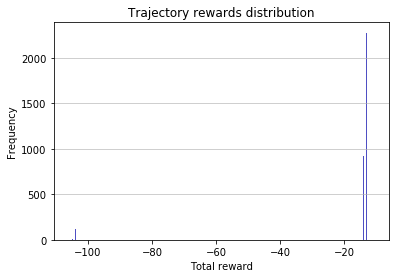

In [8]:
n, bins, patches = plt.hist(x=rewards_failure, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Total reward')
plt.ylabel('Frequency')
plt.title('Trajectory rewards distribution');

Plot the histogram of total rewards on successful trajectories


Text(0.5, 1.0, 'Trajectory rewards distribution')

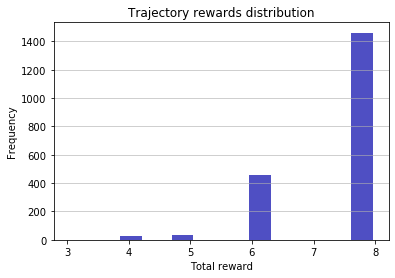

In [9]:
n, bins, patches = plt.hist(x=rewards_success, bins=12, color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Total reward')
plt.ylabel('Frequency')
plt.title('Trajectory rewards distribution');

Plot the histogram of total rewards on trajectories

Text(0.5, 1.0, 'Trajectory rewards distribution')

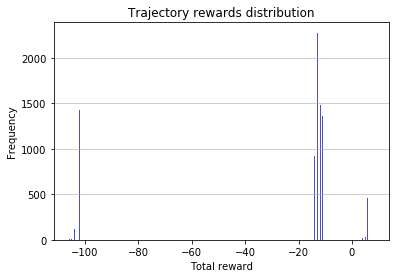

In [10]:
n, bins, patches = plt.hist(x=rewards_on_traj, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Total reward')
plt.ylabel('Frequency')
plt.title('Trajectory rewards distribution');

In [11]:
idx = pos2idx(START)
print(START)
print(idx)
print(pos2idx(GOAL))
print(GOAL)

[1, 0]
12
11
[0, 11]


In [12]:
P_a = get_transition_mat()
print(P_a[12,:,2])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


## MaxEnt IRL

In [13]:
n_actions = len(ACTIONS)
n_states = WORLD_HEIGHT * WORLD_WIDTH

lr = 0.02 # learning rate
lr_Q = 0.1 
beta = 1.0 
        
n_iters = 200 

GAMMA = 0.95
gamma = GAMMA

P_a = get_transition_mat()

# The one-hot basis is formed by the columns or rows of a unit matrix 
feature_matrix = np.eye((n_states)) 

# MaxEnt IRL
irl_rewards =  maxent_irl(feature_matrix, P_a, gamma, beta, lr, lr_Q, demos_success, n_iters)

iteration: 0/200
iteration: 10/200
iteration: 20/200
iteration: 30/200
iteration: 40/200
iteration: 50/200
iteration: 60/200
iteration: 70/200
iteration: 80/200
iteration: 90/200
iteration: 100/200
iteration: 110/200
iteration: 120/200
iteration: 130/200
iteration: 140/200
iteration: 150/200
iteration: 160/200
iteration: 170/200
iteration: 180/200
iteration: 190/200


## Display results from MaxEnt IRL and compare with ground truth

map shape: (4, 12), data type: float64
map shape: (4, 12), data type: float64
map shape: (4, 12), data type: float64
map shape: (4, 12), data type: float64
map shape: (4, 12), data type: float64
map shape: (4, 12), data type: float64
map shape: (4, 12), data type: float64
map shape: (4, 12), data type: float64


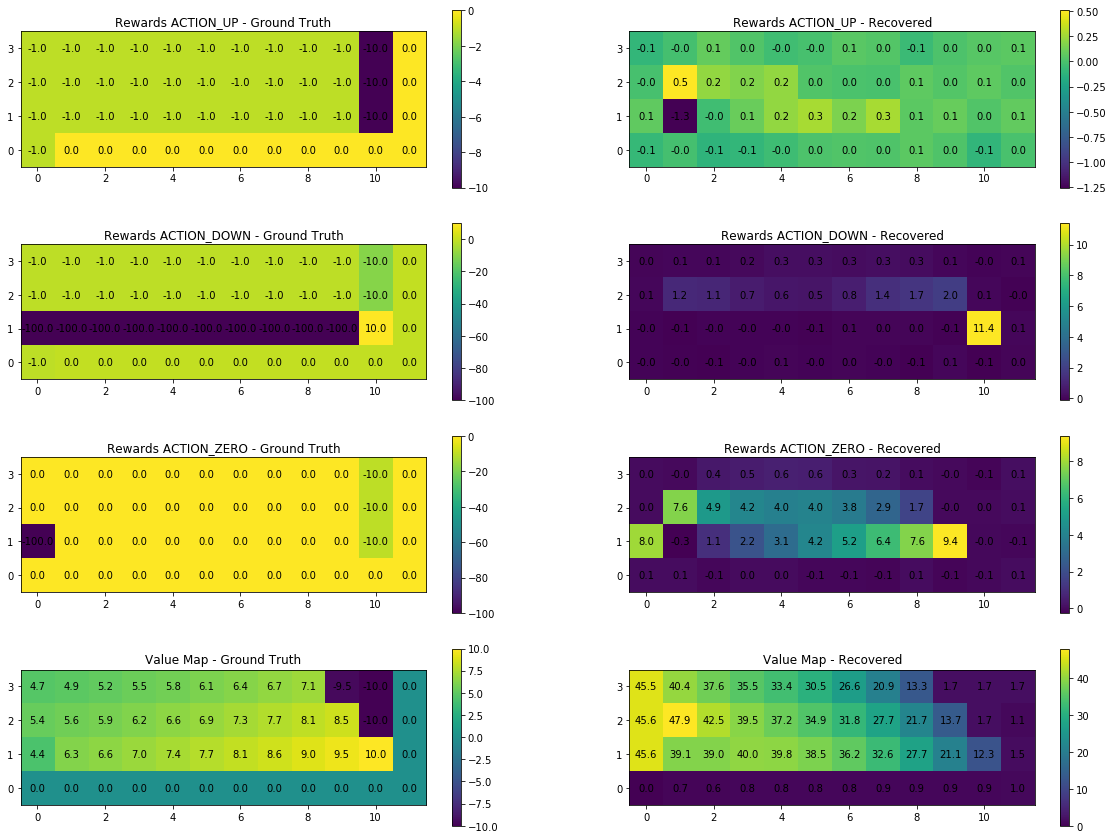

In [14]:
# ground truth rewards (shape n_state x n_actions)
gt_rewards = get_true_rewards()

# ground truth values
values_gt, _ = value_iteration(P_a, gt_rewards, GAMMA, error=0.01, deterministic=True)

# the value function recovered from IRL
values_irl, _ = value_iteration(P_a, irl_rewards, GAMMA, error=0.01, deterministic=True)

# plots
plt.figure(figsize=(20,15))

H = WORLD_HEIGHT
W = WORLD_WIDTH


plt.subplot(4, 2, 1)
heatmap2d(get_rewards_on_rectangle(gt_rewards, ACTION_UP), 
                    'Rewards ACTION_UP - Ground Truth', block=False)

plt.subplot(4, 2, 2)
heatmap2d(get_rewards_on_rectangle(irl_rewards, ACTION_UP),  
                    'Rewards ACTION_UP - Recovered', block=False)


plt.subplot(4, 2, 3)
heatmap2d(get_rewards_on_rectangle(gt_rewards, ACTION_DOWN), 
                    'Rewards ACTION_DOWN - Ground Truth', block=False)

plt.subplot(4, 2, 4)
heatmap2d(get_rewards_on_rectangle(irl_rewards, ACTION_DOWN), 
                    'Rewards ACTION_DOWN - Recovered', block=False)


plt.subplot(4, 2, 5)
heatmap2d(get_rewards_on_rectangle(gt_rewards, ACTION_ZERO), 
                    'Rewards ACTION_ZERO - Ground Truth', block=False)

plt.subplot(4, 2, 6)
heatmap2d(get_rewards_on_rectangle(irl_rewards, ACTION_ZERO), 
                    'Rewards ACTION_ZERO - Recovered', block=False)

plt.subplot(4, 2, 7)
heatmap2d(get_values_on_rectangle(values_gt), 'Value Map - Ground Truth', block=False)

plt.subplot(4, 2, 8)
heatmap2d(get_values_on_rectangle(values_irl), 'Value Map - Recovered', block=False)
plt.show()

## Run IRLF

In [15]:
n_actions = len(ACTIONS)
n_states = WORLD_HEIGHT * WORLD_WIDTH

lr = 0.02 # learning rate
lr_Q = 0.5 
beta = 1.0 

lam = 0.5 
lam_min = 1.0 
alpha_lam = 0.2

n_iters = 200 

GAMMA = 0.95 
gamma = GAMMA

P_a = get_transition_mat()

# The one-hot basis is formed by the columns or rows of a unit matrix 
feature_matrix = np.eye((n_states)) 

# take all successful demos, and the same number of randomly sampled failed trajectories

num_success = demos_success.shape[0]
num_failures = demos_failure.shape[0]
rand_idx = np.random.choice(np.arange(num_failures), num_success)

demos_failure_subset = demos_failure[rand_idx,:,:]


# IRL from failure
irlf_rewards, policy, theta_s, theta_f = irl_from_failure(feature_matrix, P_a, gamma, 
                                        beta,
                                        demos_success, 
                                        demos_failure_subset,
                                        lr,
                                        lr_Q,
                                        alpha_lam,
                                        lam,
                                        lam_min, 
                                        n_iters)


iteration: 0/200
iteration: 10/200
iteration: 20/200
iteration: 30/200
iteration: 40/200
iteration: 50/200
iteration: 60/200
iteration: 70/200
iteration: 80/200
iteration: 90/200
iteration: 100/200
iteration: 110/200
iteration: 120/200
iteration: 130/200
iteration: 140/200
iteration: 150/200
iteration: 160/200
iteration: 170/200
iteration: 180/200
iteration: 190/200


In [16]:
# for test: compare mean values of parameters defining the rewards for 'success'- and 'failure'- associated features 
print(np.mean(theta_s))
print(np.mean(theta_f))

0.7183662336982803
-0.37101827127324377


## Display results from IRLF

map shape: (4, 12), data type: float64
map shape: (4, 12), data type: float64
map shape: (4, 12), data type: float64
map shape: (4, 12), data type: float64
map shape: (4, 12), data type: float64
map shape: (4, 12), data type: float64
map shape: (4, 12), data type: float64
map shape: (4, 12), data type: float64


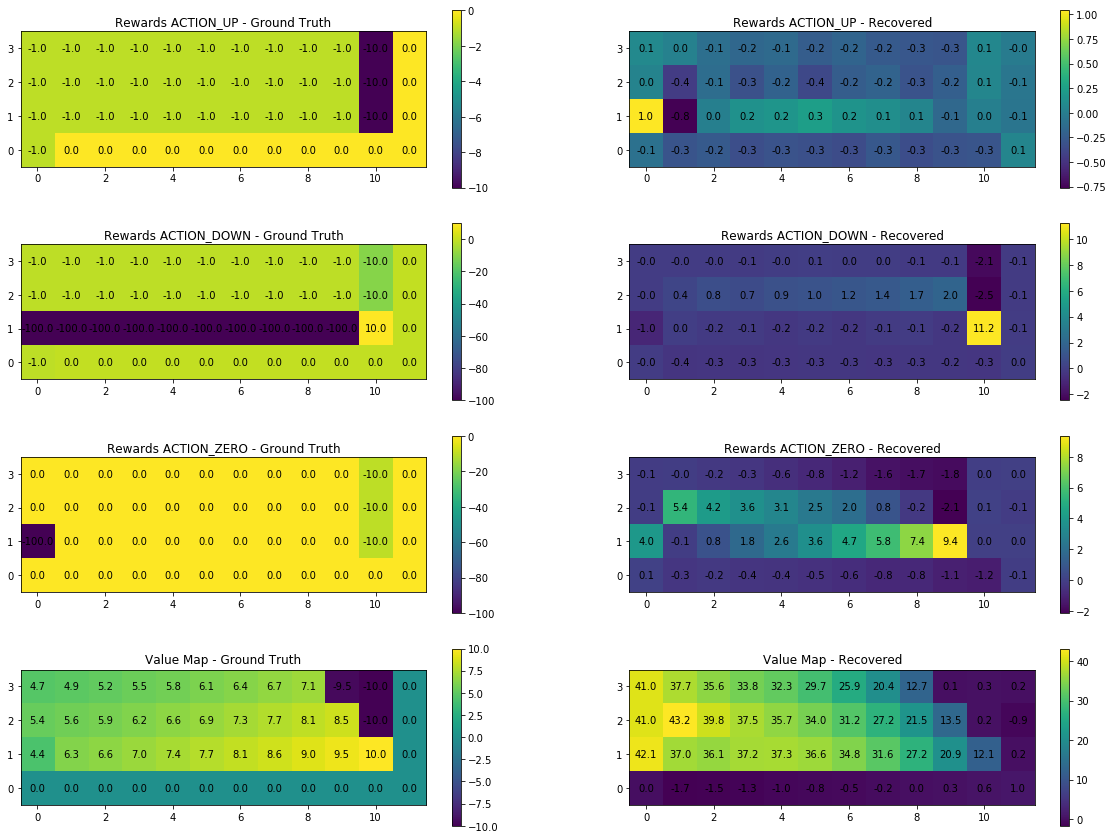

In [17]:
# ground truth rewards (shape n_state x n_actions)
gt_rewards = get_true_rewards()

# ground truth values
values_gt, _ = value_iteration(P_a, gt_rewards, GAMMA, error=0.01, deterministic=True)

# the value function recovered from IRL
values_irlf, _ = value_iteration(P_a, irlf_rewards, GAMMA, error=0.01, deterministic=True)

# plots
plt.figure(figsize=(20,15))

H = WORLD_HEIGHT
W = WORLD_WIDTH

# invert the y-axis
plt.ylim(plt.ylim()[::-1])


plt.subplot(4, 2, 1)
heatmap2d(get_rewards_on_rectangle(gt_rewards, ACTION_UP), 
                    'Rewards ACTION_UP - Ground Truth', block=False)

plt.subplot(4, 2, 2)
heatmap2d(get_rewards_on_rectangle(irlf_rewards, ACTION_UP),  
                    'Rewards ACTION_UP - Recovered', block=False)


plt.subplot(4, 2, 3)
heatmap2d(get_rewards_on_rectangle(gt_rewards, ACTION_DOWN), 
                    'Rewards ACTION_DOWN - Ground Truth', block=False)

plt.subplot(4, 2, 4)
heatmap2d(get_rewards_on_rectangle(irlf_rewards, ACTION_DOWN), 
                    'Rewards ACTION_DOWN - Recovered', block=False)


plt.subplot(4, 2, 5)
heatmap2d(get_rewards_on_rectangle(gt_rewards, ACTION_ZERO), 
                    'Rewards ACTION_ZERO - Ground Truth', block=False)

plt.subplot(4, 2, 6)
heatmap2d(get_rewards_on_rectangle(irlf_rewards, ACTION_ZERO), 
                    'Rewards ACTION_ZERO - Recovered', block=False)

plt.subplot(4, 2, 7)
heatmap2d(get_values_on_rectangle(values_gt), 'Value Map - Ground Truth', block=False)

plt.subplot(4, 2, 8)
heatmap2d(get_values_on_rectangle(values_irlf), 'Value Map - Recovered', block=False)
plt.show()

## T-REX with a tabular representation

In [19]:
import time
import numpy as np
import tensorflow as tf
import random
import torch
import torch.nn as nn
import torch.nn.functional as F

### Produce sorted trajectories

In [20]:
idx_reward_sorted = np.argsort(rewards_on_traj)
sorted_trajs = np_trajectories[np.argsort(rewards_on_traj),:,:]

In [21]:
def create_training_data(demonstrations, num_trajs, num_snippets, min_snippet_length, max_snippet_length):
    """
    Function to produce pairs of snippets of trajectories from demonstrations
    
    Returns:
    training_obs: list of tuples containing pairs of trajectory snippets
    training_labels: list of labels for these tuples (1 if the second trajectory is ranked higher, 0 otherwise)
    
    """
    # collect training data
    max_traj_length = 0
    training_obs = []
    training_labels = []
    num_demos = len(demonstrations)

    # fixed size snippets with progress prior
    for n in range(num_snippets):
        ti = 0
        tj = 0
        # only add trajectories that are different returns
        while(ti == tj):
            #pick two random demonstrations
            ti = np.random.randint(num_demos)
            tj = np.random.randint(num_demos)
        
        # create random snippets
        # find min length of both demos to ensure we can pick a demo no earlier than that chosen in worse preferred demo
        min_length = min(len(demonstrations[ti]), len(demonstrations[tj]))
        rand_length = np.random.randint(min_snippet_length, max_snippet_length)
        if ti < tj: # pick tj snippet to be later than ti
            ti_start = np.random.randint(min_length - rand_length + 1)
            tj_start = np.random.randint(ti_start, len(demonstrations[tj]) - rand_length + 1)
        else: # ti is better so pick later snippet in ti
            tj_start = np.random.randint(min_length - rand_length + 1)
            ti_start = np.random.randint(tj_start, len(demonstrations[ti]) - rand_length + 1)
        
        # override this part -IH        
        traj_i = demonstrations[ti,ti_start:ti_start+rand_length, 0:2]  # 0:2 retains only the state and action
        traj_j = demonstrations[tj,tj_start:tj_start+rand_length, 0:2]
                
        max_traj_length = max(max_traj_length, len(traj_i), len(traj_j))
        if ti > tj:
            label = 0
        else:
            label = 1
        training_obs.append((traj_i, traj_j))
        training_labels.append(label)

    print("maximum traj length", max_traj_length)
    return training_obs, training_labels


In [22]:
# test of function
# (not needed below, the function create_training_data will be called separately below)
demonstrations = sorted_trajs[0:10,:,:]

num_trajs = 10
num_snippets = 12
min_snippet_length = 4
max_snippet_length = 5

training_obs, training_labels = create_training_data(demonstrations, 
                                                     num_trajs, 
                                                     num_snippets,
                                                     min_snippet_length, 
                                                     max_snippet_length)


maximum traj length 4


## T-REX (a tabular version)

In [23]:
class T_REX_tabular(nn.Module):
    def __init__(self, n_states, n_actions, outputSize, device):
        
        super(T_REX_tabular, self).__init__()
        
        self.n_states = n_states
        self.n_actions = n_actions
        self.device = device
        
        # try initialization with zeros
        self.theta = nn.Parameter(torch.zeros((n_actions,n_states), 
                                              requires_grad=True, 
                                              dtype=torch.float, device=device))
        

    def cum_return(self, traj):
        '''calculate cumulative return of trajectory'''

        sum_rewards = 0
        sum_abs_rewards = 0
        
        # trajectory consists of sequences (state, action)
        # use these values to compute rewards as functions of theta
        
        # iterate over all rows 
        for row in traj.split(1):
            state, action = row[0,0], row[0,1]
            
            # the reward for this state-action combination is the corresponding element of 
            # array of theta
            r = self.theta[int(action.detach().numpy()), int(state.detach().numpy())]
            
            # add this reward to cumulative values
            sum_rewards = sum_rewards + r
            sum_abs_rewards = sum_abs_rewards + torch.abs(r)
                
        return sum_rewards, sum_abs_rewards


    def forward(self, traj_i, traj_j):
        '''compute cumulative return for each trajectory and return logits'''
        cum_r_i, abs_r_i = self.cum_return(traj_i)
        cum_r_j, abs_r_j = self.cum_return(traj_j)
        
        return torch.cat((cum_r_i.unsqueeze(0), cum_r_j.unsqueeze(0)),0), abs_r_i + abs_r_j


# Train the network
def learn_reward(reward_network, 
                 optimizer, 
                 training_inputs, 
                 training_outputs, 
                 num_iter, l1_reg, 
                 checkpoint_dir):
    
    # check if gpu available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    
    loss_criterion = nn.CrossEntropyLoss()
    
    cum_loss = 0.0
    training_data = list(zip(training_inputs, training_outputs))
    for epoch in range(num_iter):
        np.random.shuffle(training_data)
        training_obs, training_labels = zip(*training_data)
        for i in range(len(training_labels)):
            
            # take sub-trajectories 
            traj_i, traj_j = training_obs[i]
            labels = np.array([training_labels[i]])
            traj_i = np.array(traj_i)
            traj_j = np.array(traj_j)
            
            # convert to Pytorch tensors 
            traj_i = torch.from_numpy(traj_i).float().to(device)
            traj_j = torch.from_numpy(traj_j).float().to(device)
            labels = torch.from_numpy(labels).to(device)

            # zero out gradient
            optimizer.zero_grad()

            # forward path:
            # compute cumulative rewards and model outputs 
            # for current values of parameters
            outputs, abs_rewards = reward_network.forward(traj_i, traj_j)
            outputs = outputs.unsqueeze(0)
                      
            # the loss is cross-entropy with L1 regularization    
            loss = loss_criterion(outputs, labels) + l1_reg * abs_rewards
            
            # optimization (backward path)
            loss.backward()
            optimizer.step()

            # print stats to see if learning
            item_loss = loss.item()
            cum_loss += item_loss
            if i % 100 == 99:
                #print(i)
                print("epoch {}:{} loss {}".format(epoch,i, cum_loss))
                print(abs_rewards)
                cum_loss = 0.0
                print("check pointing")
                torch.save(reward_net.state_dict(), checkpoint_dir)
    print("finished training")


# additional functions
def calc_accuracy(reward_network, training_inputs, training_outputs):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    loss_criterion = nn.CrossEntropyLoss()
    num_correct = 0.
    with torch.no_grad():
        for i in range(len(training_inputs)):
            label = training_outputs[i]
            traj_i, traj_j = training_inputs[i]
            traj_i = np.array(traj_i)
            traj_j = np.array(traj_j)
            traj_i = torch.from_numpy(traj_i).float().to(device)
            traj_j = torch.from_numpy(traj_j).float().to(device)

            #forward to get logits
            outputs, abs_return = reward_network.forward(traj_i, traj_j)
            _, pred_label = torch.max(outputs,0)
            if pred_label.item() == label:
                num_correct += 1.
    return num_correct / len(training_inputs)

def predict_reward_sequence(net, traj):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    rewards_from_obs = []
    with torch.no_grad():
        for s in traj:
            r = net.cum_return(torch.from_numpy(np.array([s])).float().to(device))[0].item()
            rewards_from_obs.append(r)
    return rewards_from_obs

def predict_traj_return(net, traj):
    return sum(predict_reward_sequence(net, traj))

## Create training data for T-REX-tabular

In [24]:
# env_name = "beamrider"
reward_model_path = "./learned_models/FCW.params"
seed = 42
models_dir = "."
num_trajs = 10000
num_snippets = 10000

min_snippet_length = 4
max_snippet_length = 5

lr = 0.01 # 0.05 # 0.00005
weight_decay = 0.0
num_iter = 5 # num times to iterate through training data
l1_reg=0.0
stochastic = True

n_states = WORLD_HEIGHT * WORLD_WIDTH
n_actions = 3

outputDim = 1  # takes variable 'y'
epochs = 300

torch.manual_seed(seed)
np.random.seed(seed)
idx_reward_sorted = np.argsort(rewards_on_traj)
sorted_trajs = np_trajectories[np.argsort(rewards_on_traj),:,:]
sorted_traj_rewards = rewards_on_traj[idx_reward_sorted]

demonstrations = sorted_trajs[0:num_trajs,:,:]
    
training_obs, training_labels = create_training_data(demonstrations, num_trajs, num_snippets, 
                                                     min_snippet_length, max_snippet_length)


print("num training_obs", len(training_obs))
print("num_labels", len(training_labels))
   
# Now we create a reward network and optimize it using the training data.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


maximum traj length 4
num training_obs 10000
num_labels 10000


## Create and train the T-REX model 

In [25]:
import torch.optim as optim

reward_net = T_REX_tabular(n_states, n_actions, outputDim, device)
reward_net.to(device)

optimizer = optim.Adam(reward_net.parameters(),  lr=lr, weight_decay=weight_decay)

learn_reward(reward_net, optimizer, training_obs, training_labels, num_iter, l1_reg, reward_model_path)

#save reward network
torch.save(reward_net.state_dict(), reward_model_path)
  

cpu
epoch 0:99 loss 58.17791900038719
tensor(1.6595, grad_fn=<AddBackward0>)
check pointing
epoch 0:199 loss 48.009579226374626
tensor(1.6995, grad_fn=<AddBackward0>)
check pointing
epoch 0:299 loss 40.69236387126148
tensor(3.1134, grad_fn=<AddBackward0>)
check pointing
epoch 0:399 loss 34.51983254123479
tensor(2.3418, grad_fn=<AddBackward0>)
check pointing
epoch 0:499 loss 35.323562511242926
tensor(4.7131, grad_fn=<AddBackward0>)
check pointing
epoch 0:599 loss 23.575064764125273
tensor(3.5246, grad_fn=<AddBackward0>)
check pointing
epoch 0:699 loss 24.72653820796404
tensor(4.0665, grad_fn=<AddBackward0>)
check pointing
epoch 0:799 loss 29.259729997313116
tensor(4.3514, grad_fn=<AddBackward0>)
check pointing
epoch 0:899 loss 20.676631937385537
tensor(6.7476, grad_fn=<AddBackward0>)
check pointing
epoch 0:999 loss 22.474011150115984
tensor(3.9918, grad_fn=<AddBackward0>)
check pointing
epoch 0:1099 loss 18.717084266696475
tensor(5.1600, grad_fn=<AddBackward0>)
check pointing
epoch 0:11

epoch 0:9299 loss 15.510369661352435
tensor(7.3387, grad_fn=<AddBackward0>)
check pointing
epoch 0:9399 loss 19.1564694181937
tensor(9.4532, grad_fn=<AddBackward0>)
check pointing
epoch 0:9499 loss 15.495516121829745
tensor(7.8525, grad_fn=<AddBackward0>)
check pointing
epoch 0:9599 loss 9.476017415890894
tensor(8.8404, grad_fn=<AddBackward0>)
check pointing
epoch 0:9699 loss 16.547835489771273
tensor(6.6756, grad_fn=<AddBackward0>)
check pointing
epoch 0:9799 loss 14.633729979640705
tensor(12.1603, grad_fn=<AddBackward0>)
check pointing
epoch 0:9899 loss 14.021915865153993
tensor(11.4731, grad_fn=<AddBackward0>)
check pointing
epoch 0:9999 loss 23.927382387841753
tensor(5.1968, grad_fn=<AddBackward0>)
check pointing
epoch 1:99 loss 11.442068602874258
tensor(9.3197, grad_fn=<AddBackward0>)
check pointing
epoch 1:199 loss 13.615661560376331
tensor(13.5034, grad_fn=<AddBackward0>)
check pointing
epoch 1:299 loss 10.667424531423691
tensor(24.5424, grad_fn=<AddBackward0>)
check pointing
ep

epoch 1:8299 loss 10.871605325522737
tensor(6.6596, grad_fn=<AddBackward0>)
check pointing
epoch 1:8399 loss 12.464121477132984
tensor(14.2451, grad_fn=<AddBackward0>)
check pointing
epoch 1:8499 loss 13.604755588281058
tensor(18.7206, grad_fn=<AddBackward0>)
check pointing
epoch 1:8599 loss 13.59923387150883
tensor(24.6677, grad_fn=<AddBackward0>)
check pointing
epoch 1:8699 loss 17.465624659435356
tensor(7.0206, grad_fn=<AddBackward0>)
check pointing
epoch 1:8799 loss 18.660414527698457
tensor(9.7116, grad_fn=<AddBackward0>)
check pointing
epoch 1:8899 loss 16.78873842059035
tensor(9.3282, grad_fn=<AddBackward0>)
check pointing
epoch 1:8999 loss 12.337966261687853
tensor(22.7793, grad_fn=<AddBackward0>)
check pointing
epoch 1:9099 loss 11.730693678620206
tensor(10.9001, grad_fn=<AddBackward0>)
check pointing
epoch 1:9199 loss 9.602043939918829
tensor(10.1924, grad_fn=<AddBackward0>)
check pointing
epoch 1:9299 loss 11.094261485603695
tensor(12.1499, grad_fn=<AddBackward0>)
check poin

epoch 2:7299 loss 16.741173288912897
tensor(8.8992, grad_fn=<AddBackward0>)
check pointing
epoch 2:7399 loss 15.020069832632686
tensor(13.5663, grad_fn=<AddBackward0>)
check pointing
epoch 2:7499 loss 8.803333204500369
tensor(14.7005, grad_fn=<AddBackward0>)
check pointing
epoch 2:7599 loss 18.529673736848423
tensor(16.7536, grad_fn=<AddBackward0>)
check pointing
epoch 2:7699 loss 14.17593802795379
tensor(47.6666, grad_fn=<AddBackward0>)
check pointing
epoch 2:7799 loss 14.17859628774697
tensor(22.8191, grad_fn=<AddBackward0>)
check pointing
epoch 2:7899 loss 14.19440408348079
tensor(14.4004, grad_fn=<AddBackward0>)
check pointing
epoch 2:7999 loss 20.726176476533162
tensor(17.2167, grad_fn=<AddBackward0>)
check pointing
epoch 2:8099 loss 12.35041565848212
tensor(13.8230, grad_fn=<AddBackward0>)
check pointing
epoch 2:8199 loss 14.64656270154164
tensor(16.4036, grad_fn=<AddBackward0>)
check pointing
epoch 2:8299 loss 9.270101472951026
tensor(16.8150, grad_fn=<AddBackward0>)
check point

epoch 3:6299 loss 6.810872737851149
tensor(21.1975, grad_fn=<AddBackward0>)
check pointing
epoch 3:6399 loss 11.310564349418819
tensor(22.7955, grad_fn=<AddBackward0>)
check pointing
epoch 3:6499 loss 10.42829453366614
tensor(25.5715, grad_fn=<AddBackward0>)
check pointing
epoch 3:6599 loss 19.14372239557717
tensor(19.6958, grad_fn=<AddBackward0>)
check pointing
epoch 3:6699 loss 8.872906447125871
tensor(13.5564, grad_fn=<AddBackward0>)
check pointing
epoch 3:6799 loss 11.220063590180231
tensor(17.2731, grad_fn=<AddBackward0>)
check pointing
epoch 3:6899 loss 12.721879345020092
tensor(39.8197, grad_fn=<AddBackward0>)
check pointing
epoch 3:6999 loss 12.066596681241855
tensor(12.6082, grad_fn=<AddBackward0>)
check pointing
epoch 3:7099 loss 10.093918850360858
tensor(17.5463, grad_fn=<AddBackward0>)
check pointing
epoch 3:7199 loss 14.192485360105607
tensor(9.6186, grad_fn=<AddBackward0>)
check pointing
epoch 3:7299 loss 10.16247455045793
tensor(20.0676, grad_fn=<AddBackward0>)
check poi

epoch 4:5299 loss 11.358339794165431
tensor(24.9426, grad_fn=<AddBackward0>)
check pointing
epoch 4:5399 loss 21.649698631865917
tensor(16.8807, grad_fn=<AddBackward0>)
check pointing
epoch 4:5499 loss 8.24873988118565
tensor(9.6681, grad_fn=<AddBackward0>)
check pointing
epoch 4:5599 loss 13.504574619792088
tensor(17.0354, grad_fn=<AddBackward0>)
check pointing
epoch 4:5699 loss 10.028531799827604
tensor(17.0400, grad_fn=<AddBackward0>)
check pointing
epoch 4:5799 loss 14.841198450702294
tensor(22.9511, grad_fn=<AddBackward0>)
check pointing
epoch 4:5899 loss 10.7793235077243
tensor(20.3422, grad_fn=<AddBackward0>)
check pointing
epoch 4:5999 loss 6.177332460840262
tensor(10.9090, grad_fn=<AddBackward0>)
check pointing
epoch 4:6099 loss 11.189381250554575
tensor(18.0636, grad_fn=<AddBackward0>)
check pointing
epoch 4:6199 loss 20.73250396612614
tensor(12.1525, grad_fn=<AddBackward0>)
check pointing
epoch 4:6299 loss 15.5417328186466
tensor(34.0853, grad_fn=<AddBackward0>)
check pointi

## Results from T-REX

map shape: (4, 12), data type: float64
map shape: (4, 12), data type: float64
map shape: (4, 12), data type: float64
map shape: (4, 12), data type: float64
map shape: (4, 12), data type: float64
map shape: (4, 12), data type: float64
map shape: (4, 12), data type: float64
map shape: (4, 12), data type: float64


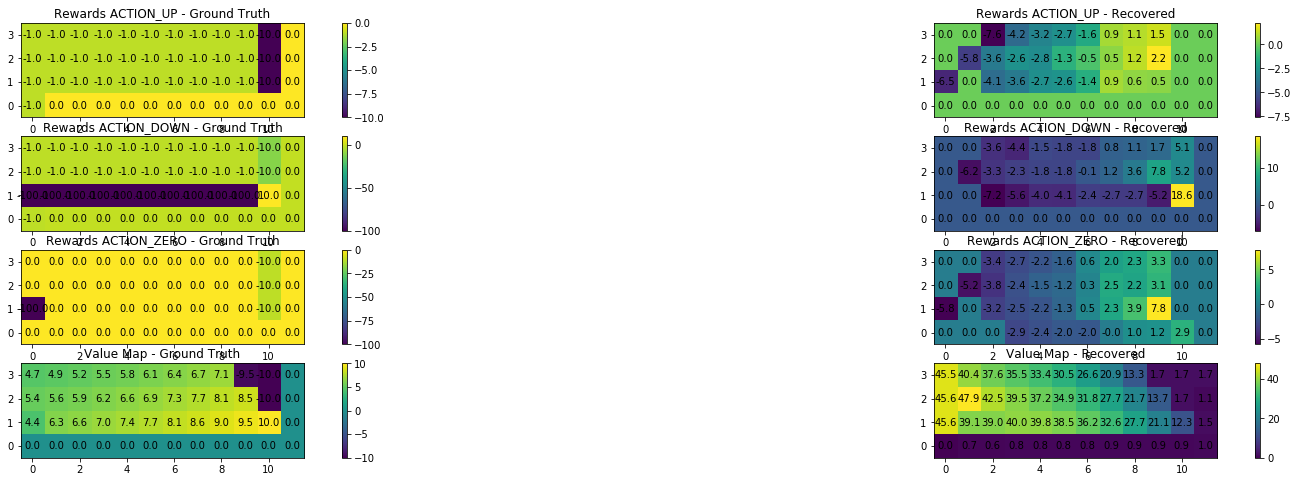

In [26]:
irl_rewards = reward_net.theta.detach().numpy().T

# plots
plt.figure(figsize=(20,15))

H = WORLD_HEIGHT
W = WORLD_WIDTH


plt.subplot(4, 2, 1)
heatmap2d(get_rewards_on_rectangle(gt_rewards, ACTION_UP), 
                    'Rewards ACTION_UP - Ground Truth', block=False)

plt.subplot(4, 2, 2)
heatmap2d(get_rewards_on_rectangle(irl_rewards, ACTION_UP),  
                    'Rewards ACTION_UP - Recovered', block=False)


plt.subplot(4, 2, 3)
heatmap2d(get_rewards_on_rectangle(gt_rewards, ACTION_DOWN), 
                    'Rewards ACTION_DOWN - Ground Truth', block=False)

plt.subplot(4, 2, 4)
heatmap2d(get_rewards_on_rectangle(irl_rewards, ACTION_DOWN), 
                    'Rewards ACTION_DOWN - Recovered', block=False)


plt.subplot(4, 2, 5)
heatmap2d(get_rewards_on_rectangle(gt_rewards, ACTION_ZERO), 
                    'Rewards ACTION_ZERO - Ground Truth', block=False)

plt.subplot(4, 2, 6)
heatmap2d(get_rewards_on_rectangle(irl_rewards, ACTION_ZERO), 
                    'Rewards ACTION_ZERO - Recovered', block=False)

plt.subplot(4, 2, 7)
heatmap2d(get_values_on_rectangle(values_gt), 'Value Map - Ground Truth', block=False)

plt.subplot(4, 2, 8)
heatmap2d(get_values_on_rectangle(values_irl), 'Value Map - Recovered', block=False)
plt.show()

map shape: (4, 12), data type: float64
map shape: (4, 12), data type: float64
map shape: (4, 12), data type: float64
map shape: (4, 12), data type: float64
map shape: (4, 12), data type: float64
map shape: (4, 12), data type: float64
map shape: (4, 12), data type: float64
map shape: (4, 12), data type: float64


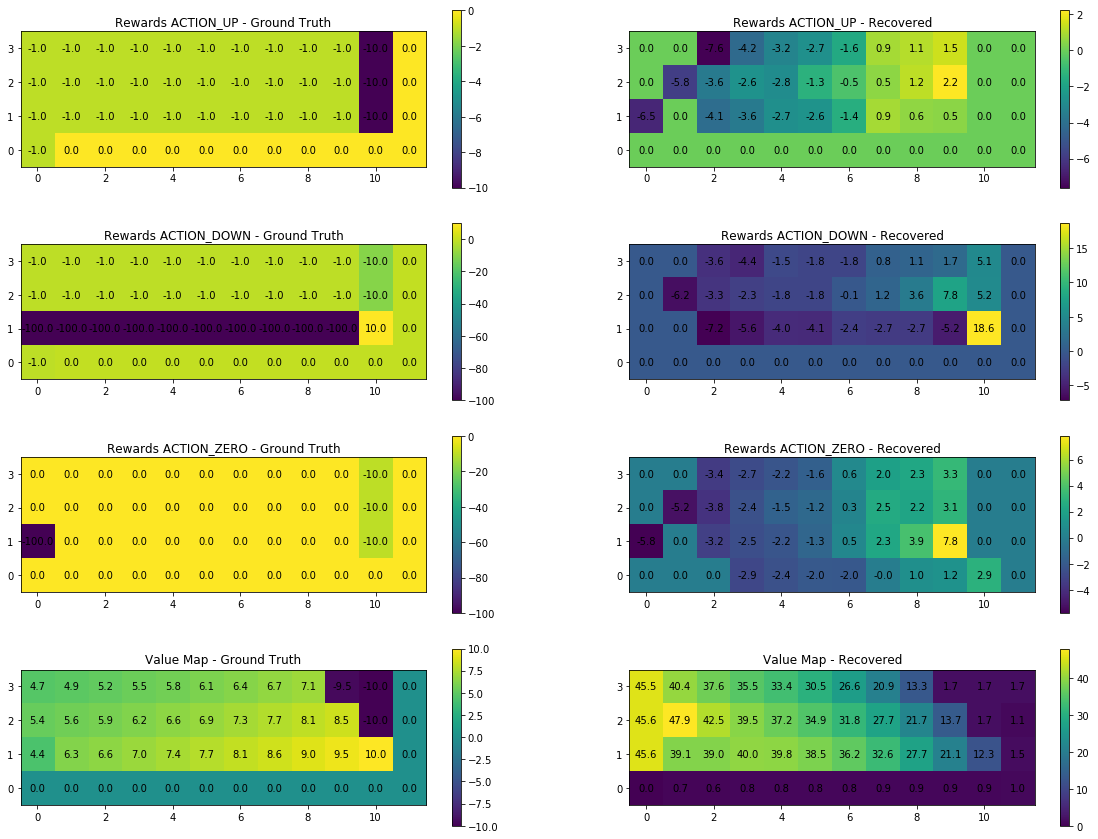

In [34]:
irl_rewards = reward_net.theta.detach().numpy().T

# plots
plt.figure(figsize=(20,15))

H = WORLD_HEIGHT
W = WORLD_WIDTH

plt.subplot(4, 2, 1)
heatmap2d(get_rewards_on_rectangle(gt_rewards, ACTION_UP), 
                    'Rewards ACTION_UP - Ground Truth', block=False)

plt.subplot(4, 2, 2)
heatmap2d(get_rewards_on_rectangle(irl_rewards, ACTION_UP),  
                    'Rewards ACTION_UP - Recovered', block=False)


plt.subplot(4, 2, 3)
heatmap2d(get_rewards_on_rectangle(gt_rewards, ACTION_DOWN), 
                    'Rewards ACTION_DOWN - Ground Truth', block=False)

plt.subplot(4, 2, 4)
heatmap2d(get_rewards_on_rectangle(irl_rewards, ACTION_DOWN), 
                    'Rewards ACTION_DOWN - Recovered', block=False)


plt.subplot(4, 2, 5)
heatmap2d(get_rewards_on_rectangle(gt_rewards, ACTION_ZERO), 
                    'Rewards ACTION_ZERO - Ground Truth', block=False)

plt.subplot(4, 2, 6)
heatmap2d(get_rewards_on_rectangle(irl_rewards, ACTION_ZERO), 
                    'Rewards ACTION_ZERO - Recovered', block=False)

plt.subplot(4, 2, 7)
heatmap2d(get_values_on_rectangle(values_gt), 'Value Map - Ground Truth', block=False)

plt.subplot(4, 2, 8)
heatmap2d(get_values_on_rectangle(values_irl), 'Value Map - Recovered', block=False)
plt.show()

map shape: (4, 12), data type: float64
map shape: (4, 12), data type: float64
map shape: (4, 12), data type: float64
map shape: (4, 12), data type: float64
map shape: (4, 12), data type: float64
map shape: (4, 12), data type: float64
map shape: (4, 12), data type: float64
map shape: (4, 12), data type: float64


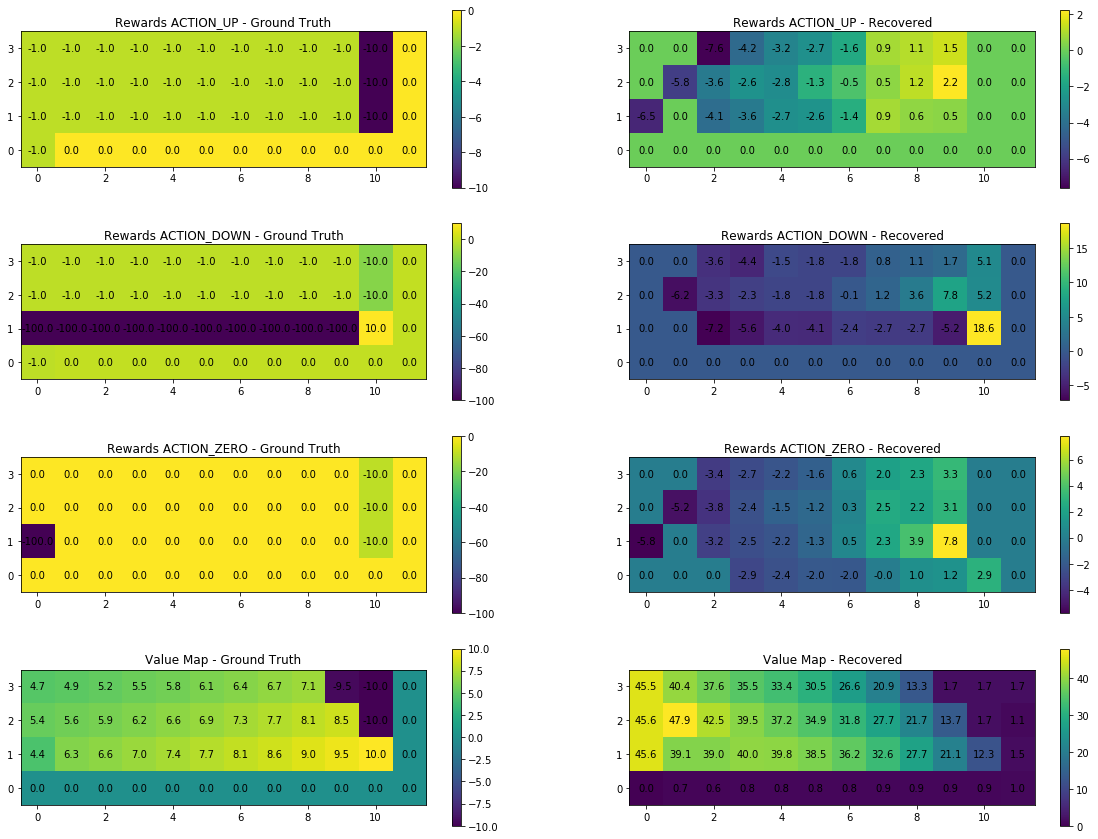

In [31]:
# results for the following choice:
irl_rewards = reward_net.theta.detach().numpy().T

# plots
plt.figure(figsize=(20,15))

H = WORLD_HEIGHT
W = WORLD_WIDTH

plt.subplot(4, 2, 1)
heatmap2d(get_rewards_on_rectangle(gt_rewards, ACTION_UP), 
                    'Rewards ACTION_UP - Ground Truth', block=False)

plt.subplot(4, 2, 2)
heatmap2d(get_rewards_on_rectangle(irl_rewards, ACTION_UP),  
                    'Rewards ACTION_UP - Recovered', block=False)


plt.subplot(4, 2, 3)
heatmap2d(get_rewards_on_rectangle(gt_rewards, ACTION_DOWN), 
                    'Rewards ACTION_DOWN - Ground Truth', block=False)

plt.subplot(4, 2, 4)
heatmap2d(get_rewards_on_rectangle(irl_rewards, ACTION_DOWN), 
                    'Rewards ACTION_DOWN - Recovered', block=False)

plt.subplot(4, 2, 5)
heatmap2d(get_rewards_on_rectangle(gt_rewards, ACTION_ZERO), 
                    'Rewards ACTION_ZERO - Ground Truth', block=False)

plt.subplot(4, 2, 6)
heatmap2d(get_rewards_on_rectangle(irl_rewards, ACTION_ZERO), 
                    'Rewards ACTION_ZERO - Recovered', block=False)

plt.subplot(4, 2, 7)
heatmap2d(get_values_on_rectangle(values_gt), 'Value Map - Ground Truth', block=False)

plt.subplot(4, 2, 8)
heatmap2d(get_values_on_rectangle(values_irl), 'Value Map - Recovered', block=False)
plt.show()

map shape: (4, 12), data type: float64
map shape: (4, 12), data type: float64
map shape: (4, 12), data type: float64
map shape: (4, 12), data type: float64
map shape: (4, 12), data type: float64
map shape: (4, 12), data type: float64
map shape: (4, 12), data type: float64
map shape: (4, 12), data type: float64


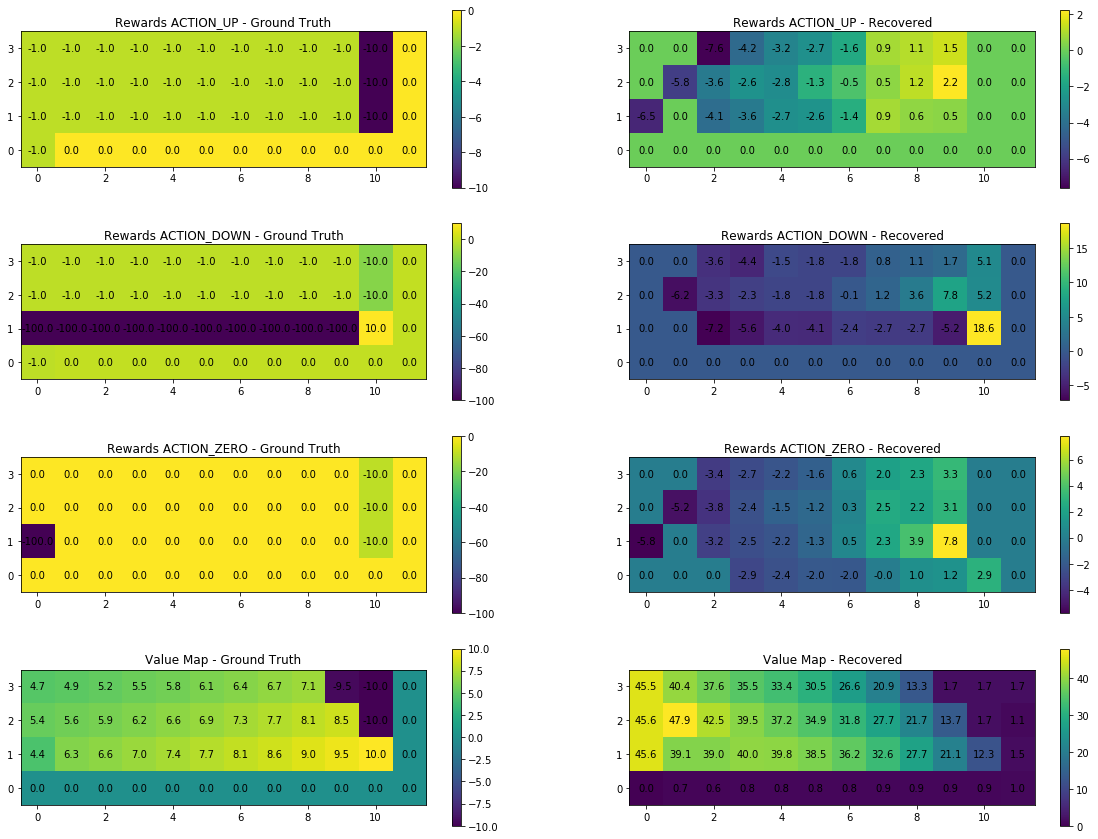

In [33]:
irl_rewards = reward_net.theta.detach().numpy().T

# plots
plt.figure(figsize=(20,15))

H = WORLD_HEIGHT
W = WORLD_WIDTH


plt.subplot(4, 2, 1)
heatmap2d(get_rewards_on_rectangle(gt_rewards, ACTION_UP), 
                    'Rewards ACTION_UP - Ground Truth', block=False)

plt.subplot(4, 2, 2)
heatmap2d(get_rewards_on_rectangle(irl_rewards, ACTION_UP),  
                    'Rewards ACTION_UP - Recovered', block=False)


plt.subplot(4, 2, 3)
heatmap2d(get_rewards_on_rectangle(gt_rewards, ACTION_DOWN), 
                    'Rewards ACTION_DOWN - Ground Truth', block=False)

plt.subplot(4, 2, 4)
heatmap2d(get_rewards_on_rectangle(irl_rewards, ACTION_DOWN), 
                    'Rewards ACTION_DOWN - Recovered', block=False)


plt.subplot(4, 2, 5)
heatmap2d(get_rewards_on_rectangle(gt_rewards, ACTION_ZERO), 
                    'Rewards ACTION_ZERO - Ground Truth', block=False)

plt.subplot(4, 2, 6)
heatmap2d(get_rewards_on_rectangle(irl_rewards, ACTION_ZERO), 
                    'Rewards ACTION_ZERO - Recovered', block=False)

plt.subplot(4, 2, 7)
heatmap2d(get_values_on_rectangle(values_gt), 'Value Map - Ground Truth', block=False)

plt.subplot(4, 2, 8)
heatmap2d(get_values_on_rectangle(values_irl), 'Value Map - Recovered', block=False)
plt.show()